In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import dill
import numpy as np
import random
mypath = 'controls_106'
_file = 'pickled_controls106.pkl'
filename = os.path.join(mypath, _file)


In [3]:
import numpy as np
import dill
pca = dill.load(open(filename, 'rb'))
num_steps = 500
dt = 5/2 * np.pi/num_steps
pca.dt = dt
pca.num_steps = num_steps

In [4]:
# Keep every_ith control. Increase this if you want to decrease the number of controls being considered.
every_ith = 8

def bangbang(index, x, d1, d2, d3, d4, num_steps):
    if x:
        xory = 0
    else:
        xory = 1
    dt = pca.dt
    control_hamiltonians = pca.control_hamiltonians
    controls = np.zeros((num_steps, int(len(pca.control_hamiltonians))))
    choices = (np.random.rand(100) - .5)/200 + 1
    controls[index, xory] = (1 / dt * np.pi / 2) * d1 * random.choice(choices)
    controls[-(index+1), xory] = 1 / dt * np.pi / 2 * d2 * random.choice(choices)
    controls[index, 2+xory] = 1 / dt * np.pi / 2 * d3 * random.choice(choices)
    controls[-(index+1), 2+xory] = 1 / dt * np.pi / 2 * d4 * random.choice(choices)
    return controls
random.seed(100)
np.random.seed(100)
controls = []
import itertools
for directions in list(itertools.product([-1, 1], repeat=4)):
    for x in (True, False):
        for i in range(int(num_steps/2)):
            if i % every_ith != 0:
                continue
            controls.append(bangbang(i, x, *directions, num_steps))
pca.controlset = []
pca.controlset += controls
#pca.controlset += [np.random.rand(*pca.controlset[0].shape)/1000]
pca.num_controls = len(pca.controlset)
pca.weights = None

In [5]:
import numpy
numpy.set_printoptions(threshold=numpy.nan)
indices = [(0, 0), (24, 0), (16,0), (8,0)]

In [6]:
from brokenaxes import brokenaxes
import matplotlib.pyplot as plt
def tophats(controls):
    n=18
    plt.figure(figsize=(10, 5))
    bax = brokenaxes(xlims=((0, n), (500-n, 500)))#, ylims=((-1, .7), (.79, 1)), hspace=.05)
    for j, control in enumerate(controls):
        times = list(range(len(control) + 1))
        points = []
        xpoints = [times[0]]
        for i, point in enumerate(control):
            points.append(point)
            points.append(point)
            xpoints.append(times[i+1])
            xpoints.append(times[i+1])
        xpoints = xpoints[:-1]
        bax.plot(xpoints, points, label=r'$\sigma_x^{}$'.format(j+1), drawstyle='steps', linestyle=['-', '--'][j])
        fontsize = 15
        plt.ylabel("Control Amplitude", labelpad=20, fontsize=fontsize)
        plt.xlabel("Timestep", labelpad=20, fontsize=fontsize)

        for ax in bax.fig.get_axes():
            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,
                left=False,
                right=False,
                labelbottom=False,
                labelleft=False) # labels along the bottom edge are off
    bax.legend(loc=4, prop={'size': fontsize})
    #plt.text(.08, 0.5, "Diamond Norm", va='center', rotation='vertical', fontsize=fontsize)
    #plt.xlabel("Detuning", fontsize=fontsize)
    return bax
    #    plt.tight_layout()

In [7]:
cs = [pca.controlset[1::32][i[0]].T[i[1]] for i in indices]

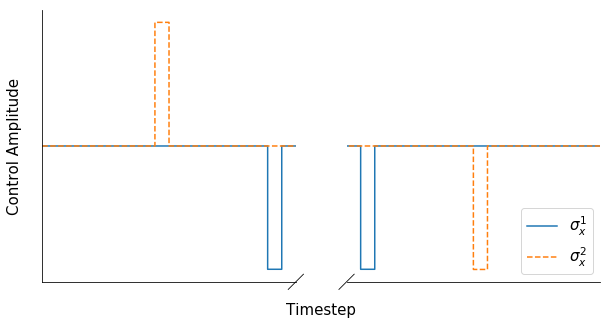

In [8]:
bax = tophats([pca.controlset[2].T[0], cs[2]])

In [9]:
len(pca.controlset)

1024

In [ ]:
from convex import all_derivs
derivs = all_derivs(pca.controlset, pca.target_operator, pca.control_hamiltonians, pca.ambient_hamiltonian, pca.dt, 1)
#derivs[1] = [np.delete(d, 2, 0) for d in derivs[1]]

In [ ]:
# Confirm that the controls are reasonably good.

In [ ]:
import scipy
[np.trace(scipy.linalg.expm(-1.j*d.reshape(4,4)))/4 for d in derivs[0]]

In [ ]:
import dill
_file = open('derivs', 'wb')
dill.dump(derivs, _file)

In [ ]:
import matplotlib.pyplot as plt
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx, np.sum(top_values)

In [ ]:
from pauli_channel_approximation import PCA

In [ ]:
from convex import optimal_weights
pca.weights_0 = optimal_weights(derivs[:1])

In [ ]:
num_weights = len(pca.controlset)

In [ ]:
idx0, supp = hist_and_support(pca.weights_0, num_weights)

In [ ]:
from convex import optimal_weights
pca.weights = optimal_weights(derivs)

In [ ]:
idx1, supp = hist_and_support(pca.weights, num_weights)

In [ ]:
pca0 = dill.load(open(filename, 'rb'))
pca0.controlset = controls
subweights =  np.array(pca.weights_0)[idx0]
pca0.controlset = []
pca0.controlset += controls
pca0.controlset += [np.zeros(controls[0].shape)]
pca0.controlset = np.array(pca0.controlset)[idx0]
pca0.weights = None


pca0.num_controls = len(pca0.controlset)
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)

In [ ]:
pca1 = dill.load(open(filename, 'rb'))
pca1.controlset = controls
subweights = np.array(pca.weights)[idx1]
pca1.controlset = []
pca1.controlset += controls
pca1.controlset += [np.zeros(controls[0].shape)]
pca1.controlset = np.array(pca1.controlset)[idx1]
pca1.weights = None


pca1.num_controls = len(pca1.controlset)
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)


In [ ]:
import scipy
order = 0
# Zeroth order optimized weights
print('ZEROTH ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx0]).T.dot(pca0.probs))))

In [ ]:
import scipy
order = 0
# Zeroth order optimized weights
print("SUM: {}".format(sum(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx0]).T.dot(pca0.probs))))

In [ ]:
import scipy
order = 1
print('FIRST ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx0]).T.dot(pca0.probs))))

In [ ]:
import scipy
order = 0
# Zeroth order optimized weights
print('ZEROTH ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx1]).T.dot(pca1.probs))))

In [ ]:
import scipy
order = 0
# Zeroth order optimized weights
print("SUM: {}".format(sum(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx1]).T.dot(pca1.probs))))

In [ ]:
import scipy
order = 1
print('FIRST ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx1]).T.dot(pca1.probs))))

In [ ]:
pca0.dt = dt
pca1.dt = dt
pca0.num_steps = num_steps
pca1.num_steps = num_steps
pca0.num_controls = len(pca0.controlset)
pca1.num_controls = len(pca1.controlset)

In [ ]:
_file = 'pickled_controls106.pkl'
# Save the weighted controls
import dill
dill.dump(pca0, open('0_' + _file, 'wb'))

import dill
dill.dump(pca1, open('1_' + _file, 'wb'))

In [3]:
# Save the weighted controls
import dill
import os
import numpy as np


pca0 = dill.load(open('0_' + _file, 'rb'))
pca1 = dill.load(open('1_' + _file, 'rb'))

In [ ]:
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
import sys
import itertools
from itertools import product
from copy import deepcopy
from functools import reduce
import numpy as np

from diamond import diamond_norm, jamiolkowski

def superoperator(unitary):

    return np.kron(unitary.conj(), unitary)

def choi_form(unitary):
    return np.matrix(jamiolkowski(superoperator(unitary)))

def diamond_distance(sopa, sopb):
    rtn = (jamiolkowski(sopa) - jamiolkowski(sopb))/2
    return diamond_norm(rtn)

def compute_diamond_norm(data):
    controlset, ambient_hamiltonian0, combo, dt, control_hamiltonians, target_operator, probs = data
    print("DOING COMBO {}".format(combo))
    sys.stdout.flush()
    fidelities = []
    projs = []
    sops = []
    controlset_unitaries = []
    d_norms = []

    for i, controls in enumerate(controlset):
        newcontrols = deepcopy(controls)
        ambient_hamiltonian = [deepcopy(ah).astype("complex") for ah in ambient_hamiltonian0]
        for cnum, value in enumerate(combo):
            cnum -= len(ambient_hamiltonian0)
            if cnum >= 0:
                newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
            if cnum < 0:
                if cnum == -1:
                    ambient_hamiltonian[cnum] *= 1 + float(value)
                else:
                    ambient_hamiltonian[cnum] *= float(value)
        step_unitaries = control_unitaries(ambient_hamiltonian,
                                           control_hamiltonians, newcontrols,
                                           dt)
        unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
        sop = error_unitary(unitary, target_operator)
        sops.append(sop)
        print("Control {}".format(i))
        if i == 0:
            d_norms.append(diamond_distance(sop, np.eye(sop.shape[0])))
    avg_sop = reduce(lambda a, b: a + b, [prob * sops[i] for i, prob in enumerate(probs)])
    d_norms.append(diamond_distance(avg_sop, np.eye(avg_sop.shape[0])))
    return d_norms

def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] 
                    for i in range(num_indices)]) for t in tuples]
    return indices

In [5]:
base = np.logspace(-4.7, np.log(pca0.detunings[0][0])/np.log(10), 1)
values = np.concatenate([np.sort(-base),np.array([0]), base]) * 100

In [ ]:
import dill
all_results = []
combinations0 = [[det, 0, 0, 0, 0, 0, 0] for det in values]
combinations1 = [[0, det, 0, 0, 0, 0, 0] for det in values]
combinations2 = [[0, 0, det, 0, 0, 0, 0] for det in values]
combinations3 = [[0, 0, 0, det, det, 0, 0] for det in values]
combinations4 = [[0, 0, 0, 0, 0, det, det] for det in values]

for j, pca in enumerate((pca0, pca1)):
    d_norms00 = []
    for i in range(len(combinations0)):
        combo = combinations0[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms00.append(compute_diamond_norm(lst))
        dill.dump(d_norms00, open('d_norms00_{}_{}'.format(i, j), 'wb'))
for j, pca in enumerate((pca0, pca1)):
    d_norms01 = []
    for i in range(len(combinations1)):
        combo = combinations1[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms01.append(compute_diamond_norm(lst))
        dill.dump(d_norms01, open('d_norms01_{}_{}'.format(i, j), 'wb'))
        
for j, pca in enumerate((pca0, pca1)):
    d_norms03 = []
    for i in range(len(combinations3)):
        combo = combinations3[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms03.append(compute_diamond_norm(lst))
        dill.dump(d_norms03, open('d_norms03_{}_{}'.format(i, j), 'wb'))
for j, pca in enumerate((pca0, pca1)):
    d_norms04 = []
    for i in range(len(combinations4)):
        combo = combinations4[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms04.append(compute_diamond_norm(lst))
        dill.dump(d_norms04, open('d_norms04_{}_{}'.format(i, j), 'wb'))

In [53]:
fontsize = 50
tickwidth = fontsize/10

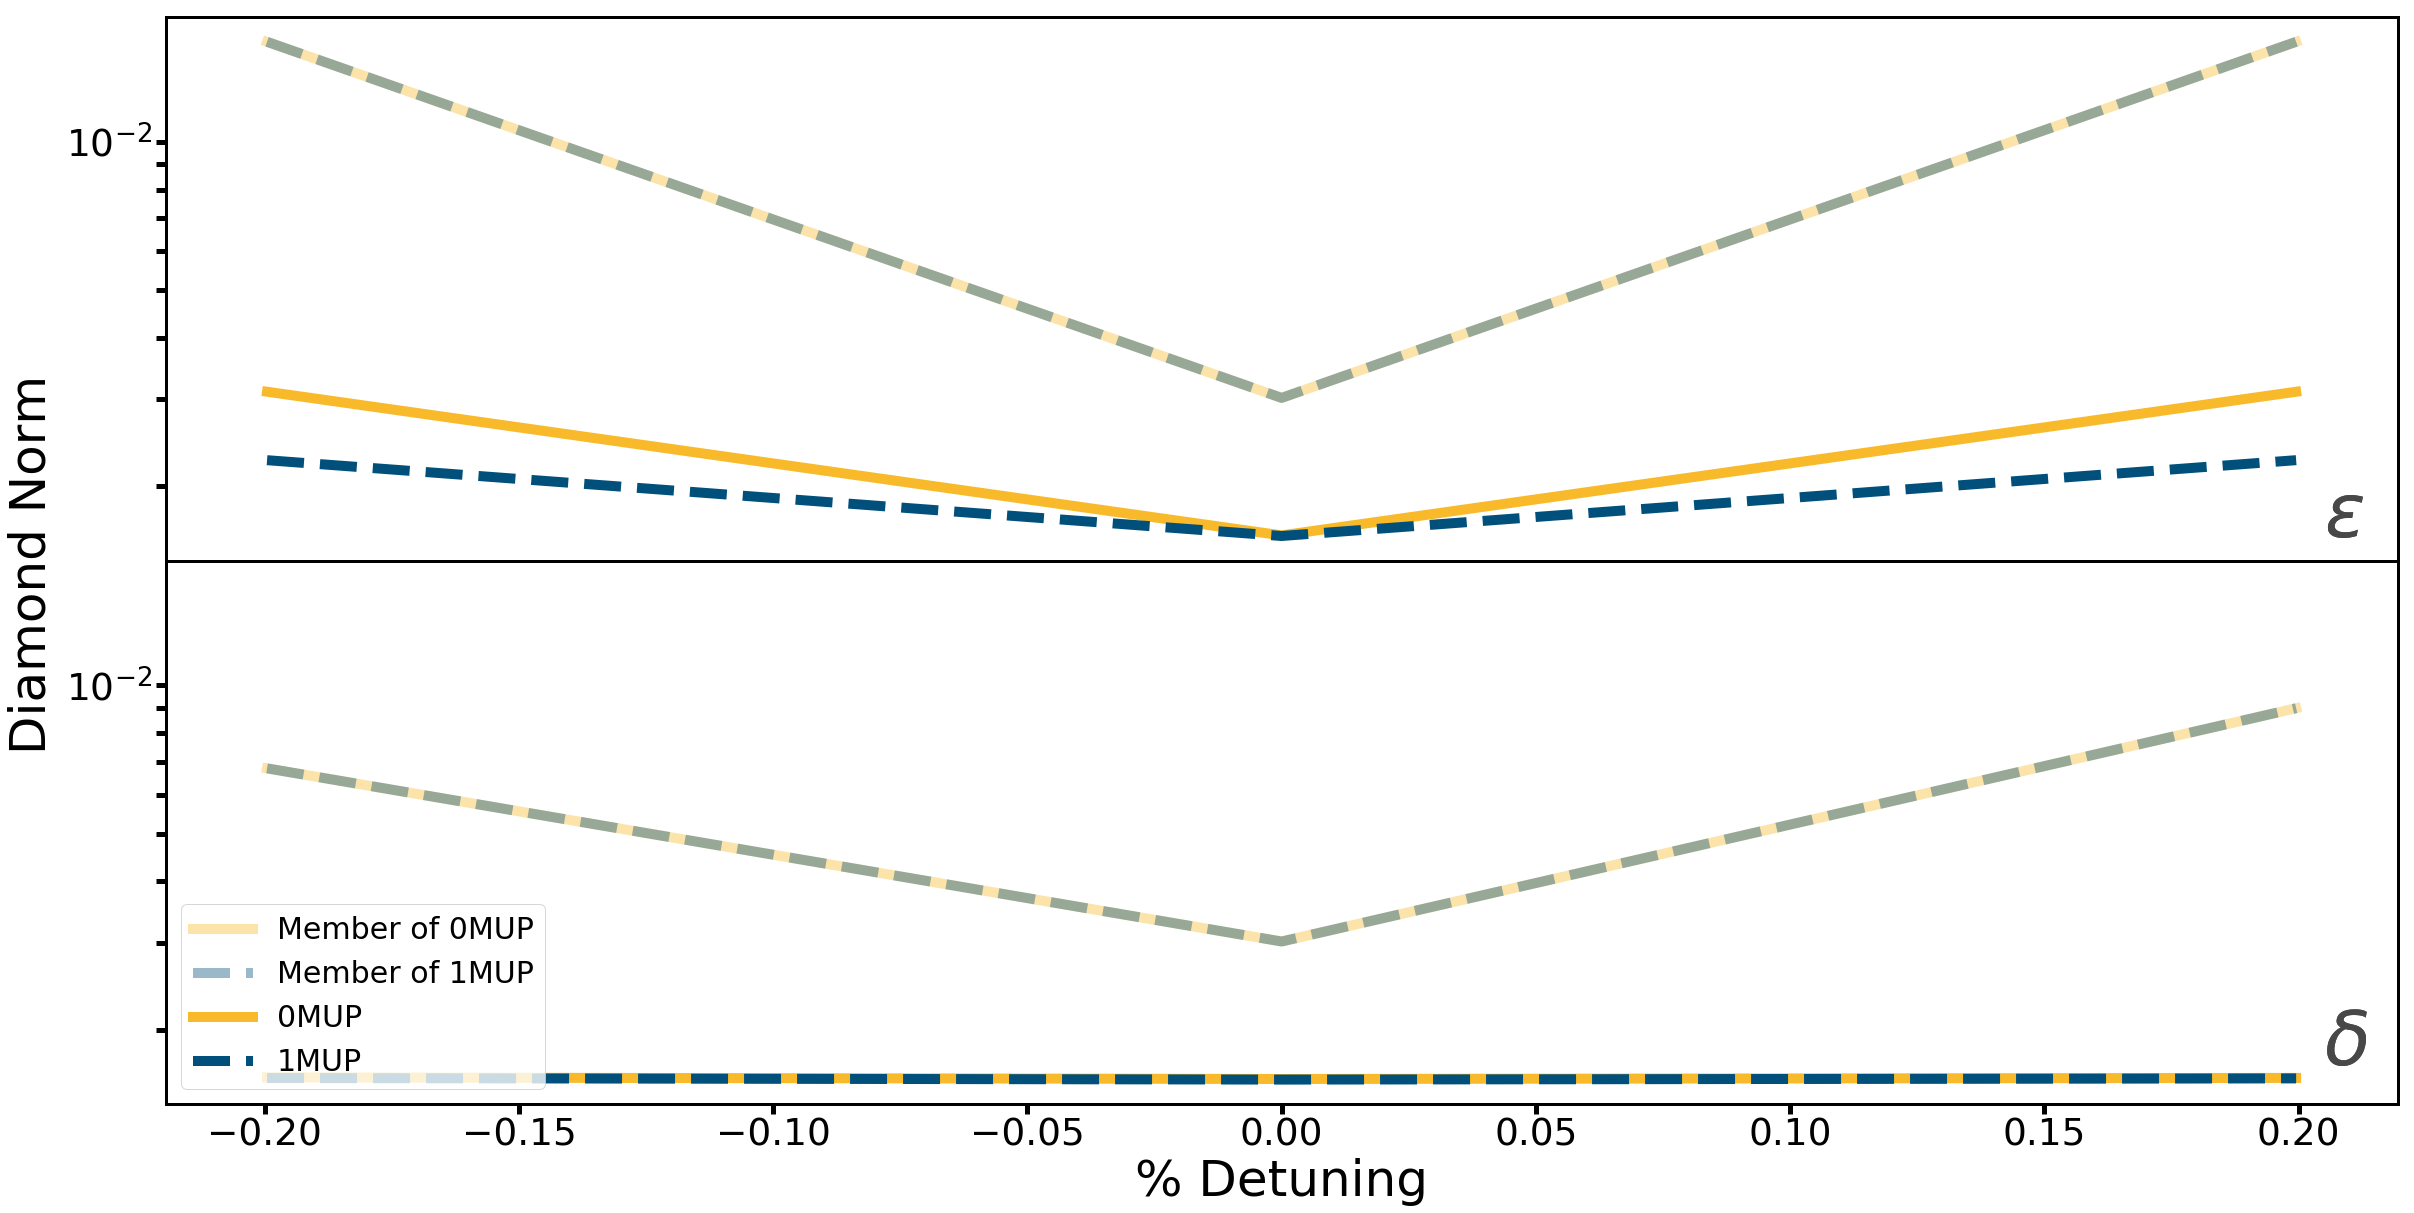

In [55]:
import dill
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 3

which_parameter = 0
f, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(40, 20))
(ax1, ax2) = axs
for i, which_parameter in enumerate([0, 1, 3, 4]):
    # Qualitatively the same.
    if i in (1, 3):
        continue
    d_norms00 = dill.load(open("d_norms0{}_2_0".format(which_parameter), 'rb'))
    d_norms10 = dill.load(open("d_norms0{}_2_1".format(which_parameter), 'rb'))
    ax = [ax1, None, ax2, None][i]
    for a, b in ((d_norms00, d_norms10),):
        ax.semilogy(values*100, np.array(a).T[0], linewidth = 10, alpha=.4, color='#f8ba2b',
                    label="Member of 0MUP", ls="-");
        ax.semilogy(values*100, np.array(b).T[0], linewidth = 10, alpha=.4, color='#00507b',
                    label="Member of 1MUP", ls="--")


        ax.semilogy(values*100, np.array(a).T[-1], linewidth = 10, alpha=1, color='#f8ba2b', label="0MUP", ls="-");
        ax.semilogy(values*100,np.array(b).T[-1], linewidth = 10, alpha=1, color='#00507b', label="1MUP", ls="--");
        ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize*3/4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fontsize*3/4)
        for which in ['major', 'minor']:
            ax.xaxis.set_tick_params(width=tickwidth, length=tickwidth*2, which=which)
            ax.yaxis.set_tick_params(width=tickwidth, length=tickwidth*2, which=which)
    plt.text(.205, .02, r'$\epsilon$', fontsize=fontsize*1.5, color='#484848')
    plt.text(.205, .0017, r'$\delta$', fontsize=fontsize*1.5, color='#484848')
    plt.subplots_adjust(wspace=0, hspace=0)
f.text(.07, 0.5, "Diamond Norm", va='center', rotation='vertical', fontsize=fontsize)
plt.xlabel("% Detuning", fontsize=fontsize)
plt.legend(prop={'size': 30}, loc=3)        


In [ ]:
#dark grey '#484848'
#navy #00507b
#lite teal #66abc4
#gold f8ba2b
#lite grey 989fa8